# Gamma 3 half-life activity introduction

This document provides the overview and procedure for teaching the Thoron-focused Gamma 3 activity in the U.C. Davis Nuclear Analytical Techniques (NAT) summer school.  Students will use a python package to analyze a single gamma peak over many HPGe counting datasets.  The analysis will yield the approximate half-life of the isotope associated with the gamma peak. Students will then performa chi-squared test by hand to test the goodness of fit.

Your group will use the HPGe data collected from the thoriated fluid to measure the half-life of an isotope in the thoron chain.  The python code in this notebook is based on a python package that can be found here:

https://github.com/pershint/NAT_HLActivity.git

# Making your data usable in python

First, let's have look at the .spe format HPGe data file contents.  Move all .spe files from your data-taking into a directory in /data/.  Then, open one of the .spe files with your favorite text editor.  Try:

`$ vim /path/to/data/datafile_name.spe`

Is this data format easily loaded/used in python?

Let's convert the .spe data files into .npz format files, which stores array-type data format using gzip compression.  A library has already been written to convert all files in a directory with .spe format into .npz.

In [1]:
import utils.spe2npz as s2n
import glob
data_files = glob.glob("./data/ThoriatedLAB_Teal_2017/*")
bkg_files = glob.glob("./data/NAT2017_Backgrounds/*")
s2n.convert(data_files)
s2n.convert(bkg_files)

08/12/2017 01:03:20

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_007
08/12/2017 15:05:57

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_021
08/12/2017 02:03:31

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_008
08/11/2017 20:02:23

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_002
08/11/2017 18:01:59

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_000
08/11/2017 23:02:57

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_005
08/12/2017 11:05:11

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_017
08/12/2017 13:05:35

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_019
08/12/2017 09:04:49

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_015
08/11/2017 19:02:11

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_001
08/12/2017 07:04:25

wrote: ./data/ThoriatedLAB_Teal_2017/NAT2017_LAB_TealsThoronSpike_013

NOTE: There are plenty of other data formats out there you could convert to (another option I consered was JSON format for this).  A different choice of data format would just mean writing a different data conversion tool.  When you choose a data format in the future, you'll have to make the decision based on what is best for your application.

# The half-life analysis

We will now load the .npz data and run the main half-life analysis script, which fits the counts per second as a function of time to the exponential expression:

$$E(C,\lambda,t) = C e^{-\lambda t}$$

Where $C$ is the counts per second at $t=0$, $t$ is the time since counting started, and $\lambda$ is the decay constant for the isotope associated with the gamma peak.

# QUIZ TIME: How is the half-liferelated to the decay constant term $\lambda$?

Let's now load the signal and background data.  A list of these file names is given to a `datacollection` class, which is essentially a container for all the data files used in the analysis.  

In [2]:
import lib.datastruct as ds

# Get the lists of all signal and background data
data_files_npz = glob.glob("./data/ThoriatedLAB_Teal_2017/*.npz")
bkg_files_npz = glob.glob("./data/NAT2017_Backgrounds/*.npz")

#Load the data arrays into the datafilecollection object
datafilecollection = ds.datacollection(listofdatafiles=data_files_npz,listofbkgdatafiles=bkg_files_npz)
datafilecollection.load_datafiles()
datafilecollection.load_bkgdatafiles()

Now, let's initialize our halflife analyzer class.  We will give the class the `datafilecollection` for performing the analysis.

In [3]:
import lib.analyzers as an
hl_analyzer = an.halflife()

Now, we need to choose a gamma peak region that will be used to calculate $E(C,\lambda,t)$.  Let's look at all open data files to get a feel for where all the gamma peaks are.

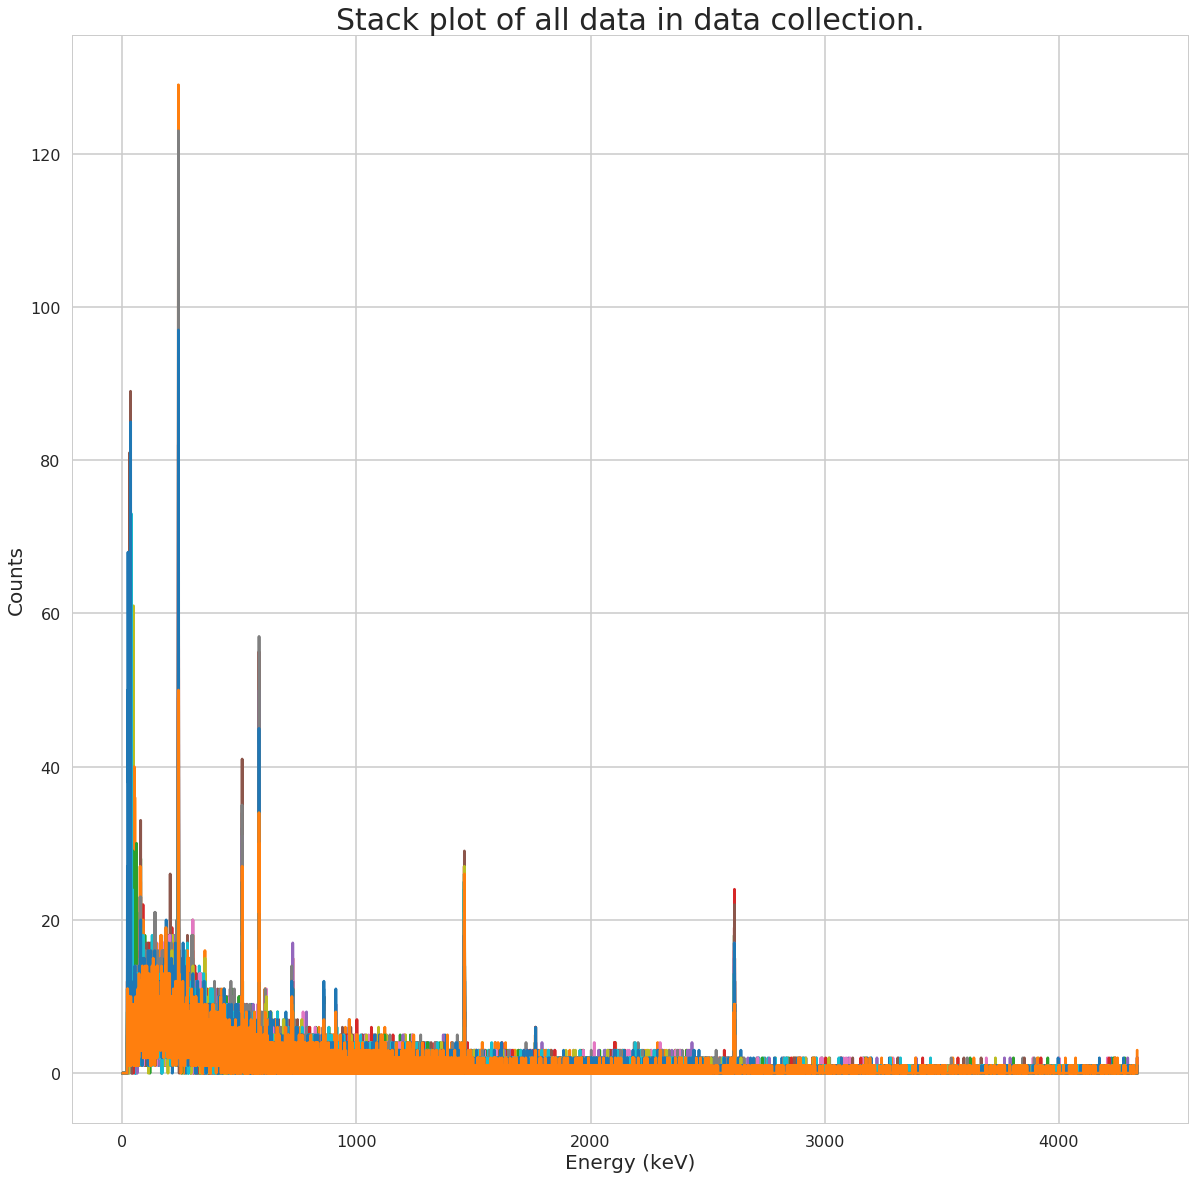

In [4]:
hl_analyzer.show_stackplot(datafilecollection.opendatafiles)

We can see several possible peaks we could look at over time.  Let's start by focusing on the peak around 240 keV.  If you want to zoom in on any other peaks, feel free to modify the x_range input.

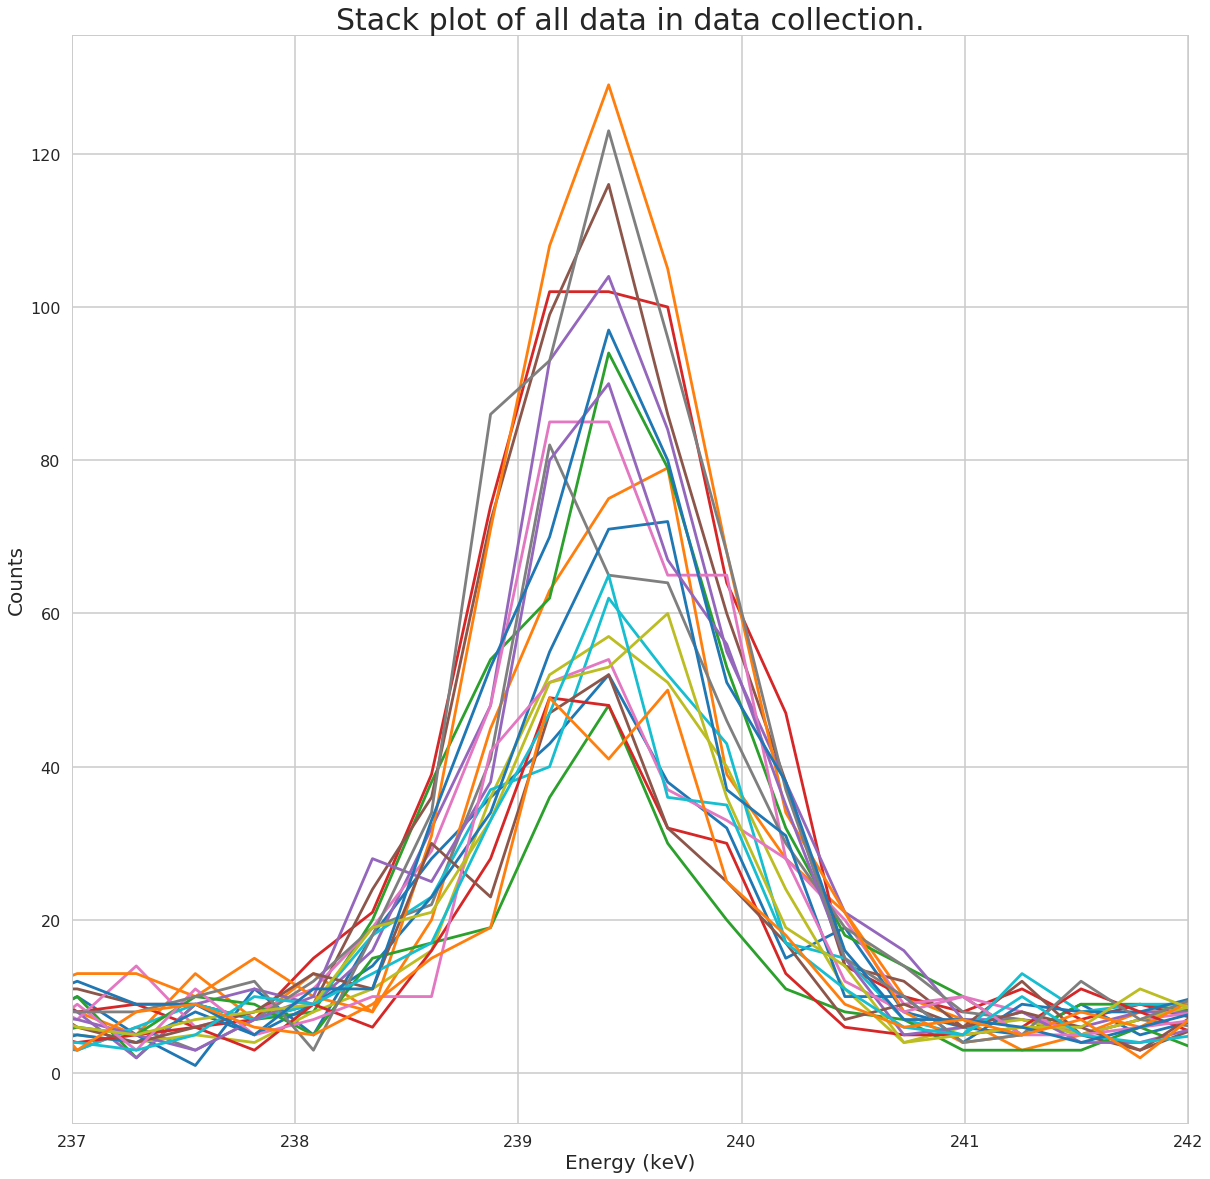

In [5]:
hl_analyzer.show_stackplot(datafilecollection.opendatafiles,x_range=[237,242])

Looking by eye, there's clearly a progression from a larger to a smaller peak.  

## Questions

- How do you best choose the peak region?  How would you go about automating this process?
- The counts in the peak are not made of only signal; there is also background activity.  How would you background subtract from the peak region?
- How are the uncertainties calculated for each background-subtracted data point?

Let's look at the integral of this peak region as a function of time.  The error bars are the statistical uncertainties discussed in the question above.

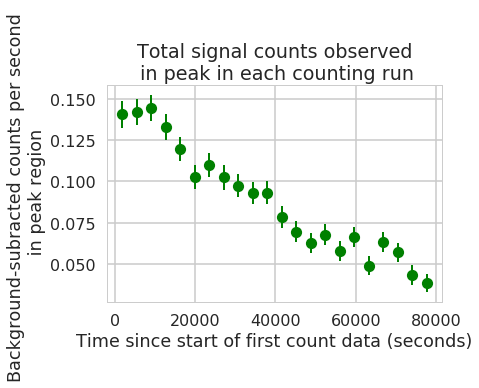

In [6]:
hl_analyzer.choose_peak(237,242)
peakdata_dict = hl_analyzer.analyze_peak(datafilecollection.opendatafiles, datafilecollection.openbkgfiles)
hl_analyzer.peakcounts_vstime(peakdata_dict)

There's a clear decrease in the counts per second within the peak region defined as time progresses.  Under the assumption that this decrease is modeled well with an exponential function, let's fit an exponential to the curve.

## The curve fit algorithm

The best fit function to the data shown above is performed using the scipy optimize library's function "curve fit".  Given some initial values for $C$ and $\lambda$, the function will calculate the following classifier:

$$\chi^{2} = \sum_{i=1}^{N} \frac{(O_{i} - E(C,\lambda,t_{i}))^{2}}{\sigma_{O_{i}}^{2}}$$

Where $O_{i}$ is the average counts per second observed for the run at time $t_{i}$.

Technically, this expression is not actually a "chi-squared" distribution unless the data come from a Gaussian distribution in each bin.  Since this often isn't the case, we refer to it as the "least squares" distribution to be pedantically correct.

For more information on the Chi Square Distribution, and how you could relate it to the goodness of your fit, here's a good "cheat sheet" resource:

https://www.physics.ohio-state.edu/~gan/teaching/spring0r/Chapter6.pdf

Then, the fitting algorithm will adjust the fit parameters $C$ and $\lambda$ slightly and re-calculate the least squares classifier.  Eventually, when the algorithm believes it has minimized the $\chi^{2}$ term, the function returns these "best fit" parameters and a covariance matrix associated with the fit.

## Questions

- Why use this expression?  Are there other metrics we can use?
- Any ideas for terms we could add to constrain/weight the fit?

Half-life results from exponential fit of deadtcorr activities:


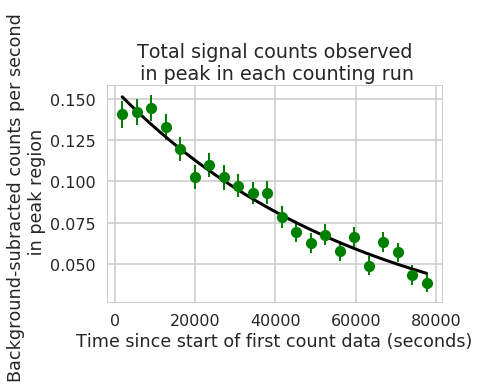

Fitted CPS at start of first data:0.1556096569215952
Fitted half-life (in hours): 11.946467372668325
Covariance matrix for fitted parameters: [[1.87563758e-05 2.70988975e-09]
 [2.70988975e-09 6.05825521e-13]]
Standard error of initial CPS fitted: 0.004330863168640457
Standard error of half-life: 0.576938903332081


In [7]:
hl_analyzer.hl_expfit(peakdata_dict)

## Questions

- What isotope in the thoron chain is your gamma associated with?  How does the half-life calculated using the fit compare to the isotope's half-life in the literature?
- If your measured half-life is considerably different than the literature, what are some possible causes?  (Hint: look up secular equilibrium)

## Uncertainties on the fit

The uncertainty on the best fit parameters is important to quantify when reporting a fit to data and propagating uncertainties to any calculation that relies on the fit parameters.  The uncertainties in the fit and fit parameters will depend on the spread in the data points, as well as the statistical uncertainty for each data bin.

In the output from the main script, notice that a covariance matrix is produced.  The covariance matris is calculated by the curve fit algorithm and provides a measure on the uncertainties for the fit parameters.  In our case, the elements of the covariance matrix are:


\begin{bmatrix}
   \sigma_{C}^{2} & \sigma_{C}\sigma_{\lambda} \\
   \sigma_{\lambda}\sigma_{C} & \sigma_{\lambda}^{2} \\
\end{bmatrix}                                                   

## Questions

- What is the difference between a statistical and systematic uncertainty?
- What kind of systematic uncertainties could we have to account for in the thoron counting measurement?